# Ariel PV segmentation with SAM

source (Huggingface): https://huggingface.co/spaces/ArielDrabkin/Solar-Panel-Detector

credits: https://blog.roboflow.com/how-to-use-yolov8-with-sam/ (Roboflow)

VI 25 with changes 15 X 25, 9 XI 25 and on

*MD*

note: a dual-use model (detection + instance segmentation)

requires OBB-versioned datasets

here: detect-YOLO

## libs

In [1]:
# %pip install numpy
# %pip install pandas
# %pip install ultralytics

In [2]:
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO, SAM
import torch
from PIL import Image

In [3]:
dev = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dev

device(type='cuda', index=0)

## defs

### data

In [4]:
pilot = 'pilotPV_panels.v1i.yolov8-obb/test/images/*.jpg'
rzeszow_test = 'rzeszowSolar panels seg.v2i.yolov8-obb/test/images/*.jpg'
rzeszow_train = 'rzeszowSolar panels seg.v2i.yolov8-obb/train/images/*.jpg'
rzeszow_valid = 'rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/*.jpg'
synth_test = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/*.jpg'
synth_train = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/*.jpg'
synth_valid = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/*.jpg'

In [5]:
proste_1_zdj = "rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg"
# proste_1_zdj = "rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Screen-Shot-2565-09-06-at-14-05-31_png_jpg.rf.e165933a680b4de6a9ea6af2df852ea7.jpg"
data_p = proste_1_zdj
pth = proste_1_zdj
nazwa = "proste_1_zdj"

### model

In [6]:
model_pt = 'final-mosaic-augmentation.pt'

In [7]:
model = YOLO(model=model_pt, task="detect", verbose=True)

In [8]:
sam = SAM("sam_b.pt")

### segment analysis

In [ ]:
def sum_pv_segments(pth, nazwa="no_info_run", model=model, print_info=False, disp_img=False, display_coef=100):
    pv_area = 0
    yolo_results = model(pth, save=print_info, name=nazwa, stream=True, device=dev, verbose=print_info)
    for i, res in enumerate(yolo_results):
        dsp = disp_img and i % display_coef == 0 # limit
        ppth = res.path # nicely conveyed
        img_w, img_h = res.orig_shape # although YOLO reshapes img when necessary, SAM masks match org img
        if dsp:
            image = cv2.cvtColor(cv2.imread(ppth), cv2.COLOR_BGR2RGB)
            image = torch.tensor(image, device=dev)
        if res is not None and res.boxes is not None and res.boxes.xyxy is not None and len(res.boxes.xyxy > 0): # null-len res.boxes.xyxy for no PV
            sam_results = sam.predict(source=ppth, bboxes=res.boxes.xyxy)
            if sam_results is not None and sam_results[0] is not None and sam_results[0].masks is not None and sam_results[0].masks.data is not None:
                binary_mask = torch.where(sam_results[0].masks.data == True, 1, 0)
                mask_sum = binary_mask.sum(axis=0).data
                mask_sum_damped = torch.where(mask_sum >= 1, 1, 0) # actually some pxs covered multiple times - same object
                if dsp:
                    bcg_white = torch.ones_like(image)*255
                    new_image = bcg_white * (1 - mask_sum_damped[..., torch.newaxis]) + image * mask_sum_damped[..., torch.newaxis]
                    plt.imshow(new_image.reshape((img_w, img_h, 3)).cpu())
                    plt.title(f"Masked PVs in {ppth[ppth.rfind('/'):]}")
                    plt.axis('off')
                    plt.show()
                    # cv2.imwrite('c.png', new_image.reshape((img_w, img_h, 3)).cpu().numpy())
                pv_area += mask_sum_damped.sum().div(img_w*img_h) # percentage
                # print('mask sums', mask_sum.sum(), mask_sum_damped.sum())
                if print_info:
                    print(i, pv_area.item())
        if dsp:
            plt.imshow(image.cpu())
            plt.title(f"base img {ppth[ppth.rfind('/'):]}")
            plt.axis('off')
            plt.show()
    return pv_area

## segment

### numbers

jeden obraz

In [10]:
sumka = sum_pv_segments(data_p, "proste_funk")
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1203.2ms
Speed: 6.4ms preprocess, 1203.2ms inference, 17.2ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.0966, device='cuda:0')

In [11]:
sumka = sum_pv_segments(data_p, "proste_funk", print_info=True)
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 704x704 4 solar-panels, 9.2ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1045.9ms
Speed: 4.3ms preprocess, 1045.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
0 0.09660888463258743
Speed: 4.4ms preprocess, 9.2ms inference, 2.7ms postprocess per image at shape (1, 3, 704, 704)
Results saved to runs/detect/proste_funk


tensor(0.0966, device='cuda:0')

podwójnie

In [12]:
sum_pv_segments([data_p,data_p], "proste_funk_podwojnie")


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1046.2ms
Speed: 5.6ms preprocess, 1046.2ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1019.4ms
Speed: 5.0ms preprocess, 1019.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.1932, device='cuda:0')

### imgs


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Screen-Shot-2565-09-06-at-14-05-31_png_jpg.rf.e165933a680b4de6a9ea6af2df852ea7.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1017.5ms
Speed: 7.0ms preprocess, 1017.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)


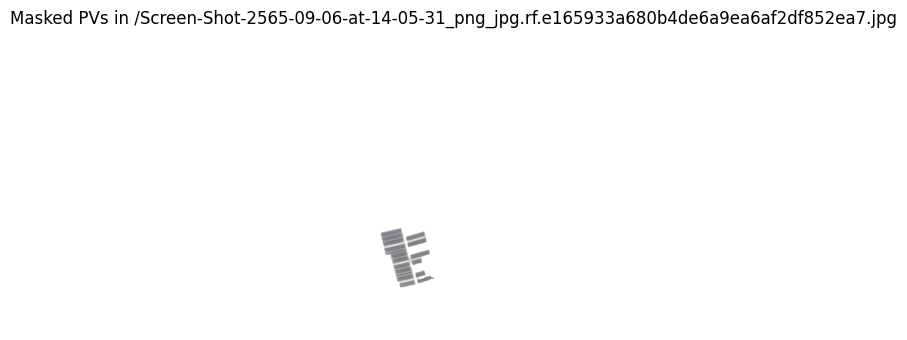

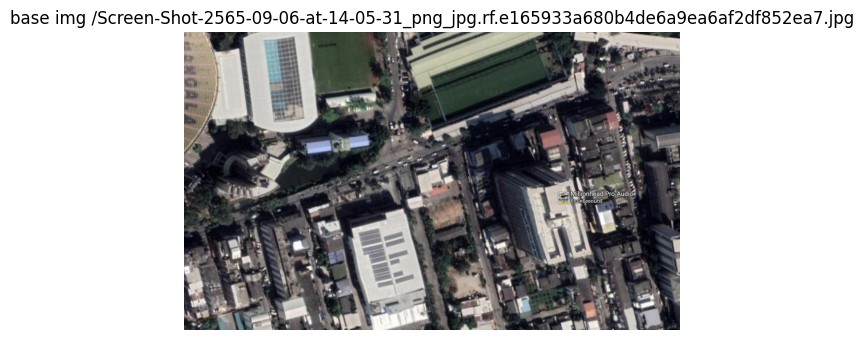

tensor(0.0137, device='cuda:0')

In [13]:
sum_pv_segments("rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Screen-Shot-2565-09-06-at-14-05-31_png_jpg.rf.e165933a680b4de6a9ea6af2df852ea7.jpg", "proste_funk", disp_img=True)

these were not nicely separated at first


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 998.1ms
Speed: 4.4ms preprocess, 998.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)


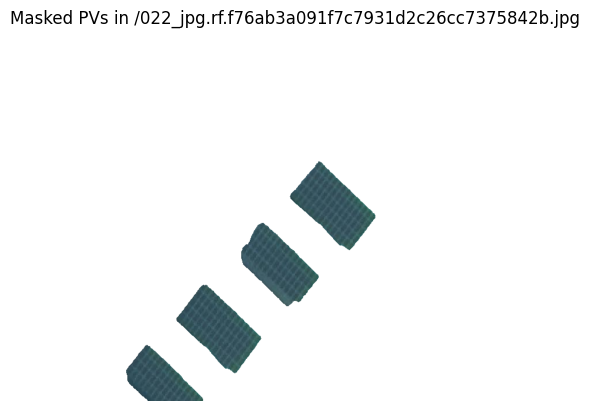

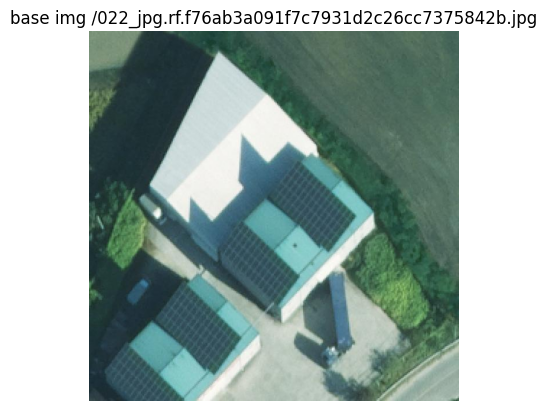

tensor(0.0966, device='cuda:0')

In [14]:
sum_pv_segments(data_p, "proste_funk", disp_img=True)

on the contrary to these neat ones


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 992.5ms
Speed: 4.1ms preprocess, 992.5ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)


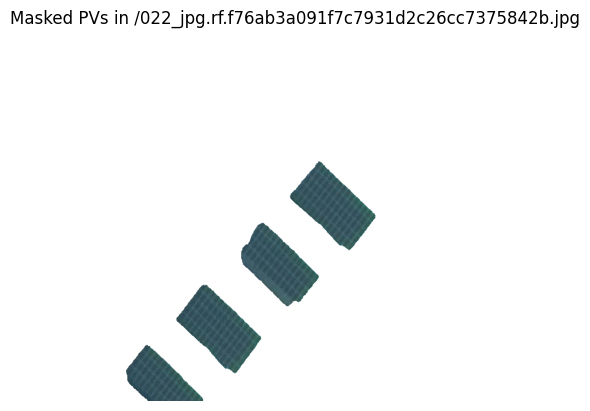

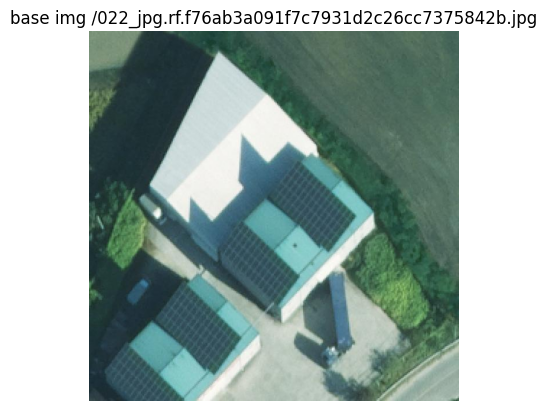


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 997.1ms
Speed: 4.8ms preprocess, 997.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.1932, device='cuda:0')

In [15]:
sum_pv_segments([data_p,data_p], "proste_funk_podwojnie", disp_img=True)

## pilot


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-291-_png.rf.c105b47207c9dc4203900bab38f73c89.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1011.1ms
Speed: 6.7ms preprocess, 1011.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


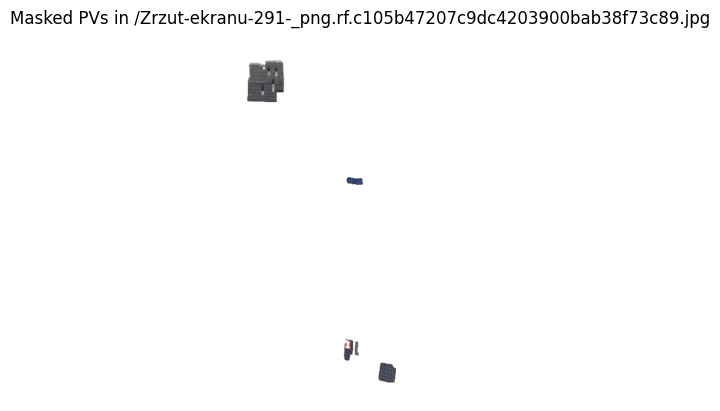

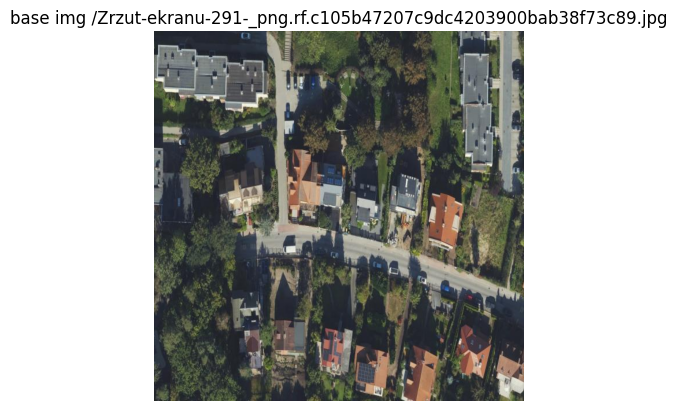


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-293-_png.rf.6501de77787921a2b0c0a3fac3ff7882.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1015.3ms
Speed: 3.8ms preprocess, 1015.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-294-_png.rf.ec19d20eeaa7c3a1ea9c829158bbebdc.jpg: 1024x1024 1 0, 969.5ms
Speed: 4.3ms preprocess, 969.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-296-_png.rf.6cb900278610471a7c56cf2c1dda3c82.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1059.7ms
Speed: 4.0ms preprocess, 1059.7ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/

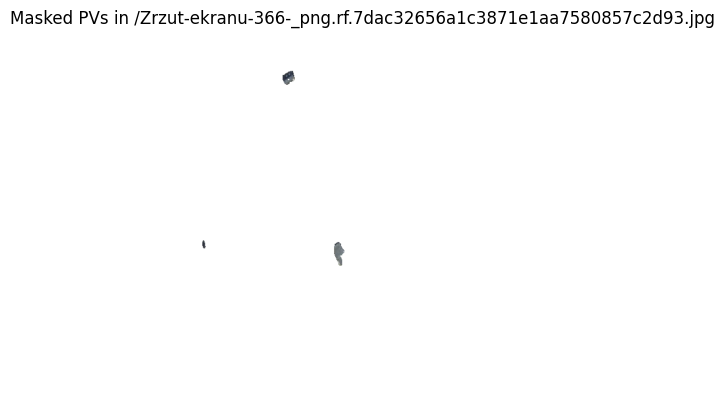

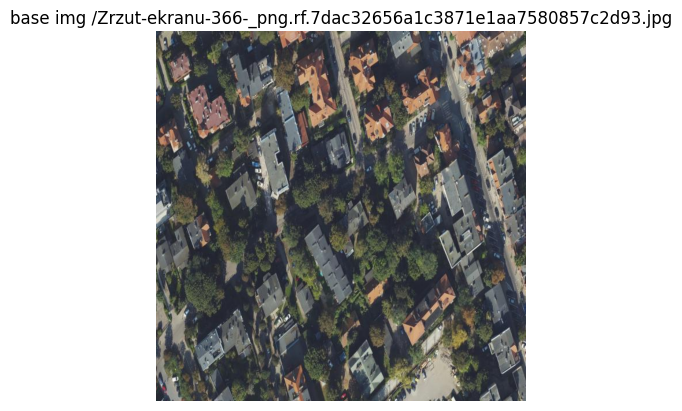


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-370-_png.rf.19faad52d9fa084df8ee42ecb144a1af.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1052.2ms
Speed: 4.6ms preprocess, 1052.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-371-_png.rf.a5aeb36b3d731bccbf03bb6872d3e06e.jpg: 1024x1024 1 0, 1 1, 1 2, 1008.4ms
Speed: 3.7ms preprocess, 1008.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-373-_png.rf.9943593aabbafa50c488d826401c6879.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 999.3ms
Speed: 3.6ms preprocess, 999.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-3

tensor(0.4996, device='cuda:0')

In [16]:
sum_pv_segments(pilot, "pilot_segment", disp_img=True, display_coef=33)

## synthetic

### train


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.71f8969cded34224572d3d3b4b7bbf07.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1032.8ms
Speed: 6.1ms preprocess, 1032.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)


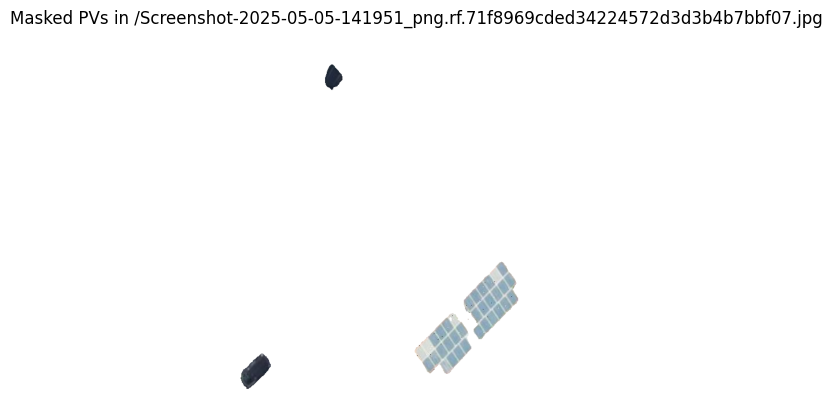

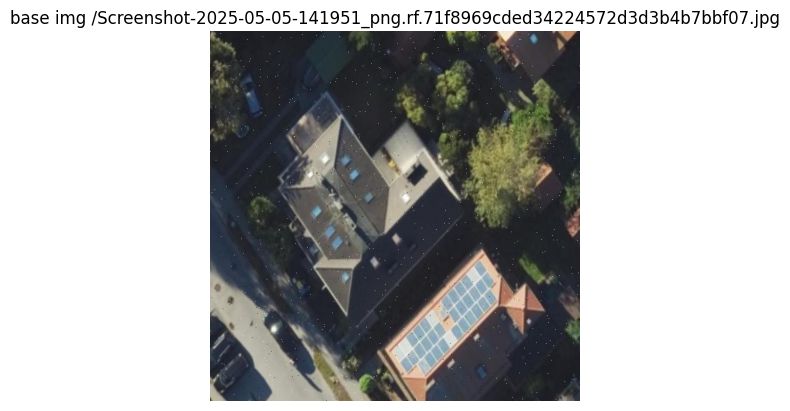


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.e8fc3301803b30373229d81dfd39a192.jpg: 1024x1024 1 0, 1 1, 1004.1ms
Speed: 4.5ms preprocess, 1004.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.fce413ee410f6a8aa17e7b99dccc1725.jpg: 1024x1024 1 0, 1 1, 976.8ms
Speed: 3.8ms preprocess, 976.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-142049_png.rf.3ba62fc2067b311bf450a681e11330af.jpg: 1024x1024 1 0, 970.1ms
Speed: 3.4ms preprocess, 970.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/

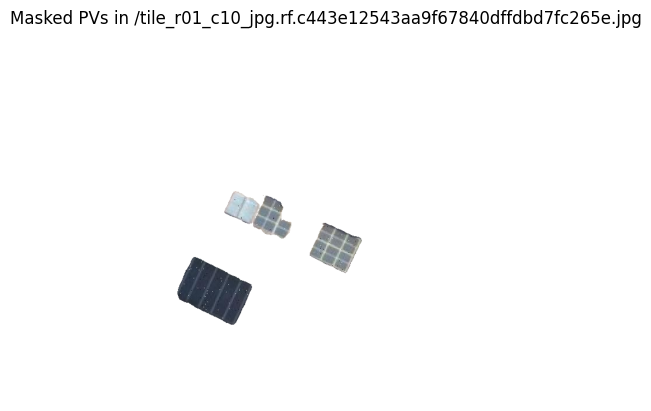

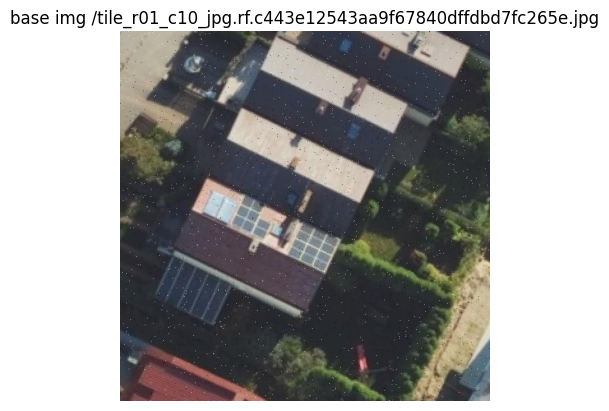


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r01_c10_jpg.rf.d0bc46921471d10337c38cf533e39d8c.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1009.1ms
Speed: 4.1ms preprocess, 1009.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r02_c01_jpg.rf.28ff9efcb558b92c9bfa835c75c62c4b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 982.9ms
Speed: 3.6ms preprocess, 982.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r02_c01_jpg.rf.a162a1877cd5a9c7802054c5044b06a9.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1020.4ms
Speed: 4.1ms preprocess, 1020.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/a

tensor(3.8197, device='cuda:0')

In [17]:
sum_pv_segments(synth_train, disp_img=True)

### valid


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142243_png.rf.0c1fc1b110982ed45002e385f2ed0cdf.jpg: 1024x1024 1 0, 1031.5ms
Speed: 7.2ms preprocess, 1031.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


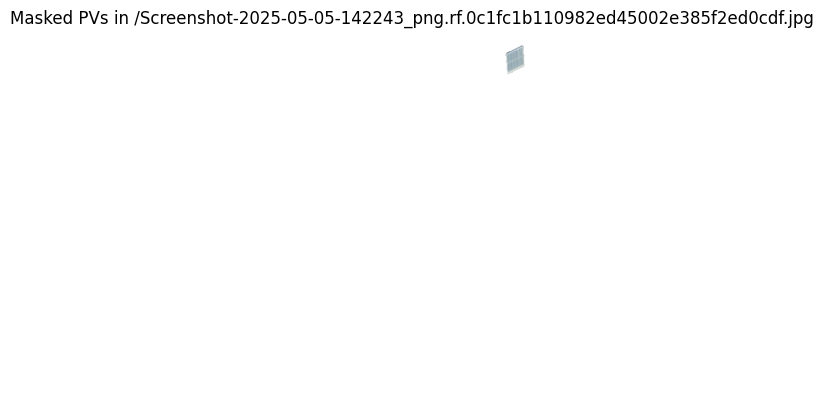

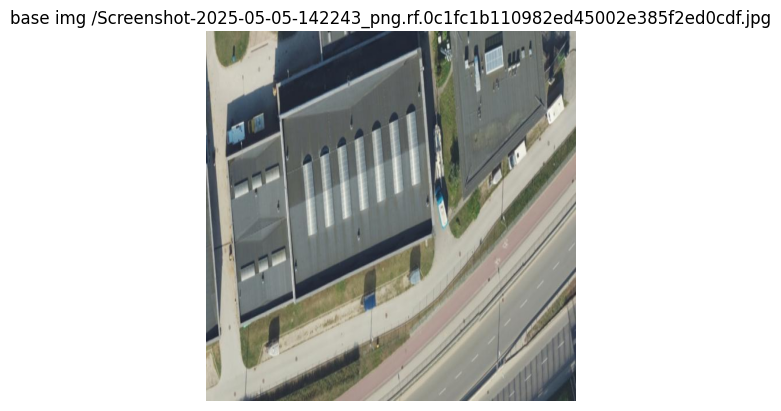


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142342_png.rf.d7373a2eee092999859ee3a20a9e7b13.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1051.5ms
Speed: 5.0ms preprocess, 1051.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142412_png.rf.7346005e071261338a10472ee5ae78b1.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1013.2ms
Speed: 3.3ms preprocess, 1013.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142633_png.rf.ab6b4d1c58ab4c00e3ddbed5118af28b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 968.2ms
Speed: 3.4ms preprocess, 968.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 10

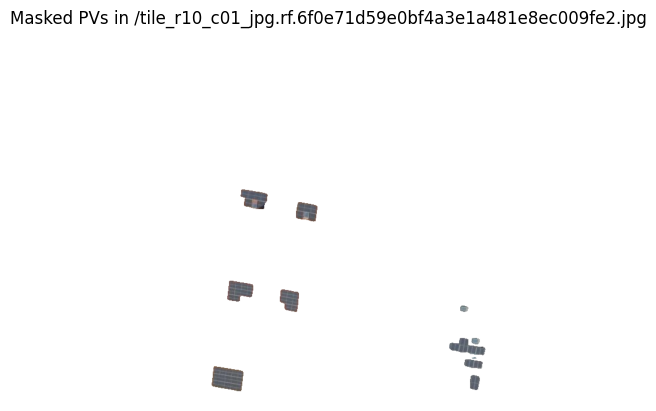

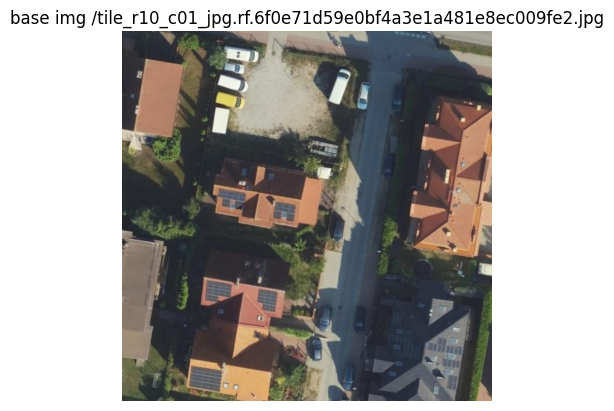


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/tile_r11_c11_jpg.rf.2911fea8c34ab33e7416cb2e7b168c9b.jpg: 1024x1024 1 0, 1 1, 1 2, 974.2ms
Speed: 4.5ms preprocess, 974.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.3348, device='cuda:0')

In [18]:
sum_pv_segments(synth_valid, disp_img=True, display_coef=10)

### test


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143003_png.rf.fdf19d2ceff2192c26f9132617f7138b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1008.2ms
Speed: 4.9ms preprocess, 1008.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)


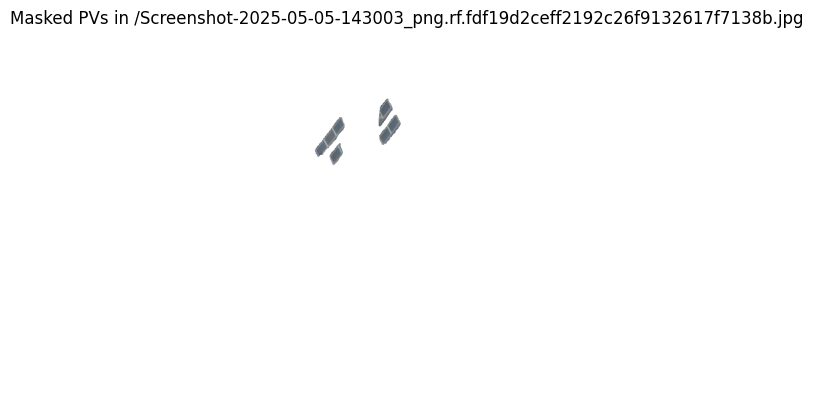

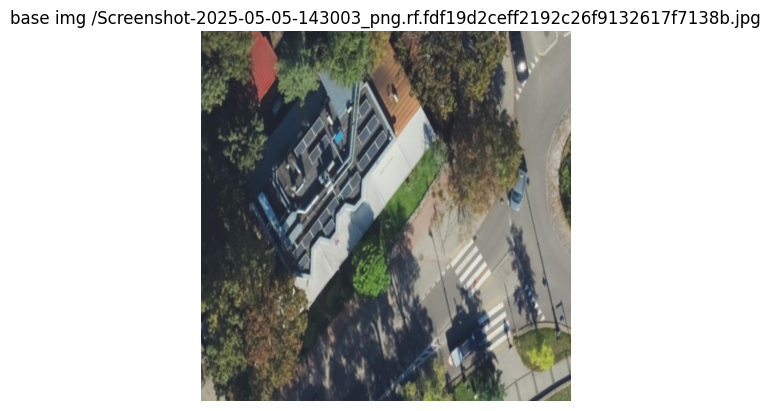


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143259_png.rf.5e77841caaec3af9f76d66e402dada53.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 989.9ms
Speed: 3.5ms preprocess, 989.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143340_png.rf.a3a5eb36c1ae28cb99b95aa17e3d2dd7.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 983.4ms
Speed: 3.4ms preprocess, 983.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143359_png.rf.fac016b09bbab7aeb2c52989c18878bd.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1011.9ms
Speed: 3.4ms preprocess, 1011.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modellin

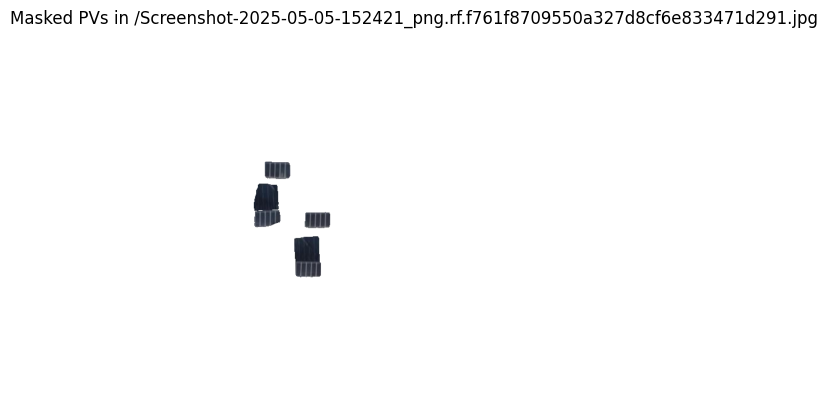

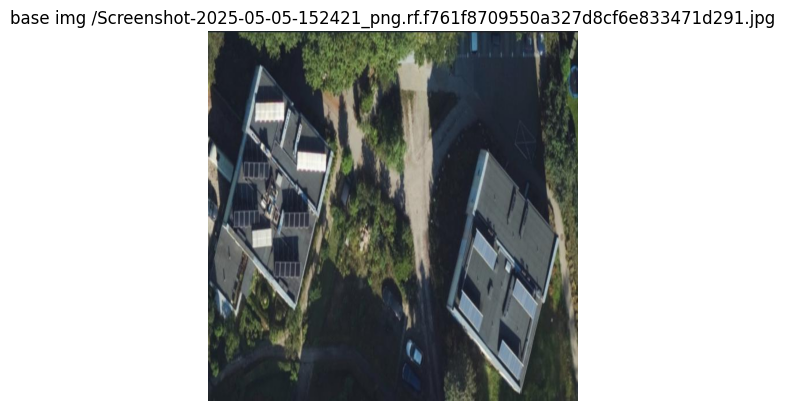


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-152659_png.rf.8f9866c533fda29648957ce56e047208.jpg: 1024x1024 1 0, 1 1, 1045.1ms
Speed: 5.3ms preprocess, 1045.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-152708_png.rf.f41dbefc9cab846445803af9b77bf4f1.jpg: 1024x1024 1 0, 1 1, 1 2, 1061.0ms
Speed: 3.5ms preprocess, 1061.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-165307_png.rf.87be249f211bca30603740bc852ccd09.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1021.1ms
Speed: 4.0ms preprocess, 1021.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.

tensor(0.5449, device='cuda:0')

In [19]:
sum_pv_segments(synth_test, disp_img=True, display_coef=10)

## Rzeszów

### valid

In [ ]:
sum_pv_segments(rzeszow_valid, disp_img=True, display_coef=333)

### test

In [ ]:
sum_pv_segments(rzeszow_test, disp_img=True, display_coef=333, print_info=True)